In [ ]:
# Load libraries
import math
import sys
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat, savemat
from scipy import signal
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential,  Model
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from keras.layers import MaxPooling2D, Conv2D, MaxPooling1D, Conv1D, Dense, Flatten, AveragePooling1D, LSTM, Dropout, Input, Concatenate, LeakyReLU, BatchNormalization, Activation
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from google.colab import files
from numpy import savetxt
from keras.layers import Layer

In [ ]:
# ==== Reproducibility Setup ====
import os
import random

seed = 0  # You can change this to any integer to control the seed globally

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Enable deterministic operations (may reduce speed slightly)
tf.config.experimental.enable_op_determinism()
# =================================

# Create a seeded initializer to ensure consistent weights
initializer = tf.keras.initializers.GlorotUniform(seed=seed)

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load raw ultrasonic data
data1 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean1.npz')
data2 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean2.npz')
data3 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean3.npz')
data4 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean4.npz')
data5 = np.load('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/Data_Extraction/Data/NPData/Npclean5.npz')

In [ ]:
# Get training time
def truncate(n,i):
  return math.floor(n*10**i)/10**i

train_time = np.concatenate((data1['Time'], data2['Time'], data3['Time'], data4['Time'], data5['Time']), axis=None)
ttime = [truncate(i,2) for i in train_time]
print(np.shape(ttime))
ttime = np.reshape(ttime, (np.shape(ttime)[0], 1))
print(ttime)
print(np.shape(ttime))

del train_time

(1324032,)
[[2102.67]
 [2102.67]
 [2102.67]
 ...
 [3426.96]
 [3426.96]
 [3426.96]]
(1324032, 1)


In [ ]:
# Collect raw ultrasonic data
train_data = np.concatenate((data1['AcData'], data2['AcData'], data3['AcData'], data4['AcData'], data5['AcData']), axis=0)
print(train_data)
print(np.shape(train_data))

[[ 21   9  26 ... -31 -33 -45]
 [ 17  20  28 ... -25 -30 -41]
 [  8  10  17 ... -17 -20 -38]
 ...
 [ 21  30  29 ... 232 242 238]
 [ 27  10  20 ... 248 239 228]
 [ 58  93 111 ... 249 224 216]]
(1324032, 1568)


In [ ]:
# Delete raw ultrasonic data
del data1, data2, data3, data4, data5

In [ ]:
# Combine ultrasound data & time
ttime = pd.DataFrame(ttime).rename(columns={0:'Time'})
full_df = ttime.join(pd.DataFrame(train_data))
print(full_df)
del train_data, ttime

            Time   0   1    2    3    4   5   6   7   8  ...  1558  1559  \
0        2102.67  21   9   26   20   31  43  25  20  31  ...     4    -6   
1        2102.67  17  20   28   24   29  40  40  35  44  ...    -6   -10   
2        2102.67   8  10   17   13   32  45  29  25  22  ...     2    -9   
3        2102.67   2   5   14    8   17  21  11  15  19  ...     3     2   
4        2102.67  15  15   10   22   29  34  19  19  27  ...    -1     3   
...          ...  ..  ..  ...  ...  ...  ..  ..  ..  ..  ...   ...   ...   
1324027  3426.96  24  22   18   36   36  26  24  19  21  ...   248   260   
1324028  3426.96  24  16   21   32   31  27  22  15  34  ...   258   261   
1324029  3426.96  21  30   29   30   25  35  34  30  36  ...   268   275   
1324030  3426.96  27  10   20   29   28  29  38  21  25  ...   265   258   
1324031  3426.96  58  93  111  124  115  89  44  35  19  ...   256   269   

         1560  1561  1562  1563  1564  1565  1566  1567  
0           1    -2   -11   -

In [ ]:
# Drop duplicate time data
full_df = full_df.drop_duplicates(subset=['Time'], keep='last').reset_index(drop=True)
full_df = full_df.set_index('Time')
print(full_df)

         0     1     2     3     4     5     6     7     8     9     ...  \
Time                                                                 ...   
2102.67    20    17    14    13    35    49    37    37    23    19  ...   
2102.68    10    16    20    13    34    34    33    37    24    16  ...   
2102.69    18    14    18    28    23    31    26    22    20     4  ...   
2102.70    26    13    22    26    25    35    25    25    40    14  ...   
2102.71    14    11     9    20    31    34    29     2     5    13  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
3426.92     9    18    19    16    41    23    12    29    18     3  ...   
3426.93    17    24    16    23    19    17    20    21    28    12  ...   
3426.94    10    12    25    13    27    50    25    27    19     2  ...   
3426.95     3    15    21    23    39    38    21    23    22    15  ...   
3426.96    58    93   111   124   115    89    44    35    19   -14  ...   

         15

In [ ]:
# Load shear stress data
data = loadmat('/content/drive/My Drive/Colab Notebooks/p5270/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
m_t = m_t[:][175604:175604+132400].reset_index(drop=True)
print(m_t)

           Time        SS
0       2102.91  5.657157
1       2102.92  5.658317
2       2102.93  5.659499
3       2102.94  5.660404
4       2102.95  5.661648
...         ...       ...
132395  3426.86  5.474545
132396  3426.87  5.478286
132397  3426.88  5.481751
132398  3426.89  5.484813
132399  3426.90  5.487332

[132400 rows x 2 columns]


In [ ]:
# Merge raw ultrasonic data & shear stress based on time
# Prepare input data (xdf): raw ultrasonic signal
# Prepare output data (ydf): shear stress
df = full_df.reset_index().merge(m_t, on='Time').reset_index(drop=True)
xdf = df.drop(['Time', 'SS'], axis=1)
ydf = df[['SS']]
print(xdf)
print(ydf)

        0     1     2     3     4     5     6     7     8     9     ...  1558  \
0         16    23    16    31    33    27    24    26    32    17  ...     0   
1         15    19    32    30    31    40    34    28    37    17  ...    -5   
2          9    16    20    27    36    44    21    10    26    12  ...    28   
3         26    24    21    22    27    36    28    24    17     7  ...    -5   
4         10    14    24    28    35    36    26    25    17    20  ...    -4   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
132371    25    37    15    19    39    30    35    30    21    28  ...   253   
132372    20    14     7    10    27    18    21    21    32    21  ...   254   
132373    22     9    17    27    33    29    15    14     5    17  ...   260   
132374    24    17     8    18    31    46    36    19    34    24  ...   266   
132375    17    20    33    33    38    39    27    17    19    25  ...   257   

        1559  1560  1561  1

In [ ]:
# Split data in train-val-test (72-8-20)
x_train, x_test1, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train1, X_val1, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.125, shuffle=False)

del x_train, y_train

In [ ]:
# Reshape data & scaling
X_train = np.reshape(X_train1.values, (-1,1))
X_val = np.reshape(X_val1.values, (-1,1))
x_test = np.reshape(x_test1.values, (-1,1))

del X_train1, X_val1, x_test1

sc = MinMaxScaler(feature_range=(-1,1))
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
x_test = sc.transform(x_test)

X_train = np.reshape(X_train, (-1,1568))
X_val = np.reshape(X_val, (-1,1568))
x_test = np.reshape(x_test, (-1,1568))

print(X_train.shape, X_val.shape, x_test.shape)
print(Y_train.shape, Y_val.shape,y_test.shape)

(92662, 1568) (13238, 1568) (26476, 1568)
(92662, 1) (13238, 1) (26476, 1)


In [ ]:
# Reshape in the tensor form
X_train = np.reshape(np.array(X_train), (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(np.array(X_val), (X_val.shape[0], X_val.shape[1], 1))
x_test = np.reshape(np.array(x_test), (x_test.shape[0], x_test.shape[1], 1))
print(X_train.shape, X_val.shape, x_test.shape)

(92662, 1568, 1) (13238, 1568, 1) (26476, 1568, 1)


In [ ]:
# Input Signal
inp = Input(shape=(1568, 1))

# CNN 1
x = Conv1D(32, kernel_size=7)(inp)
x = BatchNormalization()(x)
x = Activation(LeakyReLU())(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# CNN 2
x = Conv1D(32, kernel_size=5)(x)
x = BatchNormalization()(x)
x = Activation(LeakyReLU())(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# CNN 3
x = Conv1D(16, kernel_size=5)(x)
x = BatchNormalization()(x)
x = Activation(LeakyReLU())(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# CNN 4
x = Conv1D(16, kernel_size=3)(x)
x = BatchNormalization()(x)
x = Activation(LeakyReLU())(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# CNN 5
x = Conv1D(8, kernel_size=3)(x)
x = BatchNormalization()(x)
x = Activation(LeakyReLU())(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# CNN 6
x = Conv1D(8, kernel_size=3)(x)
x = BatchNormalization()(x)
x = Activation(LeakyReLU())(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# CNN 7
x = Conv1D(1, kernel_size=1)(x)
x = BatchNormalization()(x)
x = Activation(LeakyReLU())(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# CNN 8
x = Conv1D(1, kernel_size=1)(x)
x = BatchNormalization()(x)
x = Activation(LeakyReLU())(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# Extract Features
f2 = Flatten(name='Features')(x)

# Regression Output
op = Dense(1, activation='linear')(f2)

# Build Model
model = Model(inputs=inp, outputs=op)

# Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1568, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1562, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1562, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1562, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 781, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 777, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 777, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 777, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 388, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 384, 16)        │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 384, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 384, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 192, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 190, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 190, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 190, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 93, 8)          │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 93, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 93, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 46, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 44, 8)          │           200 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,833 (38.41 KB)

 Trainable params: 9,605 (37.52 KB)

 Non-trainable params: 228 (912.00 B)

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.03815, saving model to /content/drive/My Drive/Colab Notebooks/p5270/XAI/Attention_Layer/Check1.keras
Epoch 2/10

Epoch 2: val_loss did not improve from 0.03815
Epoch 3/10

Epoch 3: val_loss did not improve from 0.03815
Epoch 4/10

Epoch 4: val_loss did not improve from 0.03815
Epoch 5/10

Epoch 5: val_loss did not improve from 0.03815
Epoch 6/10

Epoch 6: val_loss did not improve from 0.03815
Epoch 7/10

Epoch 7: val_loss did not improve from 0.03815
Epoch 8/10

Epoch 8: val_loss did not improve from 0.03815
Epoch 9/10

Epoch 9: val_loss did not improve from 0.03815
Epoch 10/10

Epoch 10: val_loss did not improve from 0.03815


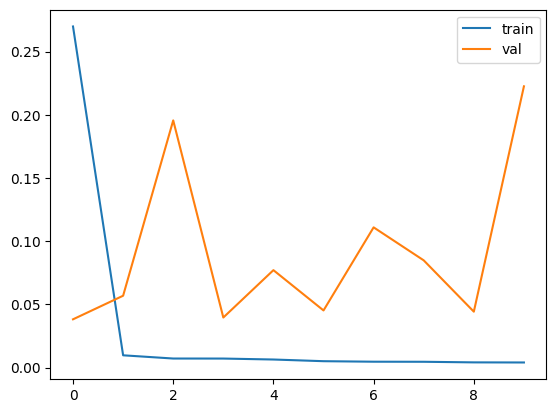

In [ ]:
# Model: compile, summary & fit
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='auto')  #Stops when accuracy is no longer changing
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/p5270/XAI/Attention_Layer/Check1.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  #Saves best model so far
callbacks_list = [earlystop, checkpoint]


history = model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=10, callbacks=callbacks_list, validation_data=(X_val, Y_val))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
# # Evaluate the model
# # Backward-looking averaing of 10 obervations

# # Training
# y_predTrain = model.predict(X_train)
# y_predTrain = pd.DataFrame(y_predTrain).rolling(10, min_periods=1).mean().astype('float32')
# train_r2 = r2_score(Y_train, y_predTrain)
# train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

# # #Validation
# y_predVal = model.predict(X_val)
# y_predVal = pd.DataFrame(y_predVal).rolling(10, min_periods=1).mean().astype('float32')
# val_r2 = r2_score(Y_val, y_predVal)
# val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))

# # # Testing
# start_time = time.time()
# y_predTest = model.predict(x_test)
# y_predTest = pd.DataFrame(y_predTest).rolling(10, min_periods=1).mean().astype('float32')
# end_time = time.time()
# test_r2 = r2_score(y_test, y_predTest)
# test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

# # Print scores
# print("R^2 scores: ", train_r2, val_r2, test_r2)
# print("RMSE: ", train_rmse, val_rmse, test_rmse)
# print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Plot
# def results_plot(fig_no, gt, pred, title, col):
#   fig = plt.figure(fig_no, figsize=(20,3))
#   plt.plot(gt)
#   plt.plot(pred, col)
#   plt.xlabel('Time (s)')
#   plt.ylabel('Shear Stress (MPa)')
#   plt.legend(['Ground truth', 'Predicted'])
#   plt.title(title)

# results_plot(1, Y_train, y_predTrain, 'Training data', '')
# results_plot(2, Y_val.values, y_predVal, 'Testing data', 'g')
# results_plot(3, y_test.values, y_predTest, 'Validation data', 'r')

In [ ]:
# Evaluate the model
# Backward-looking averaing of 10 obervations

# Training
y_predTrain = model.predict(X_train)
y_predTrain = pd.DataFrame(y_predTrain)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

# #Validation
y_predVal = model.predict(X_val)
y_predVal = pd.DataFrame(y_predVal)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))

# # Testing
start_time = time.time()
y_predTest = model.predict(x_test)
y_predTest = pd.DataFrame(y_predTest)
end_time = time.time()
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

# Print scores
print("R^2 scores: ", train_r2, val_r2, test_r2)
print("RMSE: ", train_rmse, val_rmse, test_rmse)

2896/2896 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
828/828 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
R^2 scores:  -3.846447895446919 -9.305508897194585 -6.665487410582046
RMSE:  0.2811420311804136 0.47173397859801475 0.4009364141663641


In [ ]:
# # Extracted features (training set)

intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('Features').output)
intermediate_output_train = intermediate_layer_model.predict(X_train)
# print(intermediate_output.shape)
# for i in range(0,intermediate_output.shape[1], 50):
#   fig = plt.figure(i, figsize=(20,4))
#   mc = pd.DataFrame(intermediate_output[:,i]).rolling(10, min_periods=1).mean().astype('float32')
#   plt.plot(mc)
#   plt.ylabel('Feature')

# savetxt('training_features.csv', intermediate_output, delimiter=',')
# files.download('training_features.csv')

2896/2896 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


In [ ]:
# # Extracted features (validation set)

intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('Features').output)
intermediate_output_val = intermediate_layer_model.predict(X_val)
# print(intermediate_output.shape)
# for i in range(0,intermediate_output.shape[1], 50):
#   fig = plt.figure(i, figsize=(20,4))
#   mc = pd.DataFrame(intermediate_output[:,i]).rolling(10, min_periods=1).mean().astype('float32')
#   plt.plot(mc)
#   plt.ylabel('Feature')

# savetxt('validation_features.csv', intermediate_output, delimiter=',')
# files.download('validation_features.csv')

414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [ ]:
# # Extracted features (test set)

intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('Features').output)
intermediate_output_test = intermediate_layer_model.predict(x_test)
# print(intermediate_output.shape)
# for i in range(0,intermediate_output.shape[1], 50):
#   fig = plt.figure(i, figsize=(20,4))
#   mc = pd.DataFrame(intermediate_output[:,i]).rolling(10, min_periods=1).mean().astype('float32')
#   plt.plot(mc)
#   plt.ylabel('Feature')

# savetxt('testing_features.csv', intermediate_output, delimiter=',')
# files.download('testing_features.csv')

828/828 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [ ]:
Amp_Feature = np.vstack((intermediate_output_train, intermediate_output_val, intermediate_output_test))
print(Amp_Feature.shape)

(132376, 5)


In [ ]:
ydf_new = ydf.to_numpy()
print(ydf_new.shape)

(132376, 1)


In [ ]:
df_SS = np.hstack((Amp_Feature, ydf_new))
print(df_SS.shape)

(132376, 6)


In [ ]:
savetxt('Features_SS.csv', df_SS, delimiter=',')
files.download('Features_SS.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>